$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [122]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw4/answers.py`.

In [123]:
import cs236781.plot as plot
import cs236781.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\user\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\user\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\user\.pytorch-datasets\lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [124]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


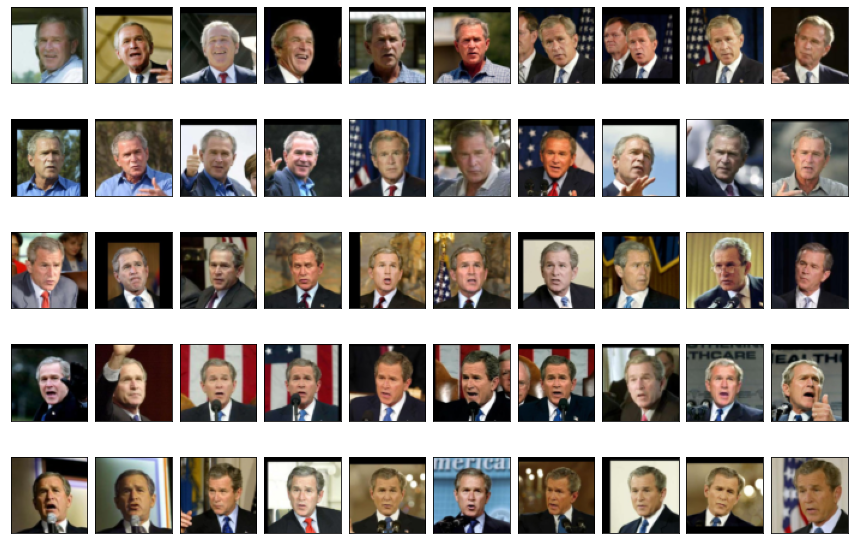

In [125]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [126]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw4/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [127]:
import hw4.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.1)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.1)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(1024, 1, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.1)
  )
)
torch.Size([1, 

**TODO**: Implement the `Generator` class in the `hw4/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [130]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw4/gan.py` module.

In [131]:
from hw4.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw4/gan.py` module.

In [132]:
from hw4.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw4/gan.py` module.

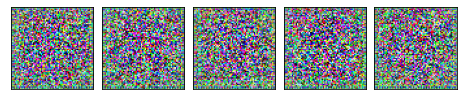

In [133]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw4/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw4/answers.py` module.

In [134]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw4.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 8, 'z_dim': 128, 'data_label': 0, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0015, 'betas': (0.45, 0.89)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.001, 'betas': (0.45, 0.89)}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw4.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 67/67 [01:44<00:00,  1.56s/it]
Discriminator loss: 0.9589664125398024
Generator loss:     9.458030945329524
0.0
Saved checkpoint.


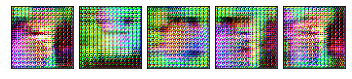

--- EPOCH 2/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.62s/it]
Discriminator loss: 0.342141428100529
Generator loss:     15.306981426566395
0.09511826535712747
Saved checkpoint.


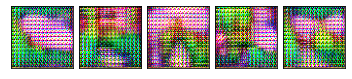

--- EPOCH 3/100 ---
100%|██████████| 67/67 [01:55<00:00,  1.72s/it]
Discriminator loss: 0.6276265642981032
Generator loss:     18.156615798153094
0.06352899105012107
Saved checkpoint.


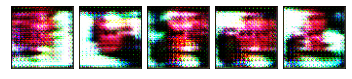

--- EPOCH 4/100 ---
100%|██████████| 67/67 [01:53<00:00,  1.69s/it]
Discriminator loss: 0.6839212530584478
Generator loss:     19.15623596533021
0.04796208124600645
Saved checkpoint.


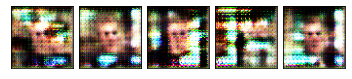

--- EPOCH 5/100 ---
100%|██████████| 67/67 [01:56<00:00,  1.75s/it]
Discriminator loss: 0.7880556234784091
Generator loss:     11.473977429653281
0.04128098870101733
Saved checkpoint.


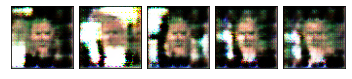

--- EPOCH 6/100 ---
100%|██████████| 67/67 [01:58<00:00,  1.76s/it]
Discriminator loss: 0.9431138912132427
Generator loss:     11.800434789550838
0.04400555735800651
Saved checkpoint.


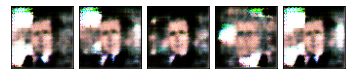

--- EPOCH 7/100 ---
100%|██████████| 67/67 [01:49<00:00,  1.64s/it]
Discriminator loss: 0.2605341672897339
Generator loss:     21.630483378225296
0.06401785366731257
Saved checkpoint.


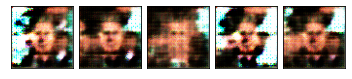

--- EPOCH 8/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.63s/it]
Discriminator loss: 1.2148703149339157
Generator loss:     11.475599266032674
0.08996186395649369
Saved checkpoint.


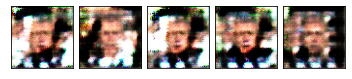

--- EPOCH 9/100 ---
100%|██████████| 67/67 [01:49<00:00,  1.64s/it]
Discriminator loss: 0.9286596551537514
Generator loss:     11.78830430845716
0.08396649208201888
Saved checkpoint.


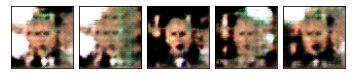

--- EPOCH 10/100 ---
100%|██████████| 67/67 [01:49<00:00,  1.64s/it]
Discriminator loss: 1.1103249078811104
Generator loss:     10.127324449037438
0.08727012203850923
Saved checkpoint.


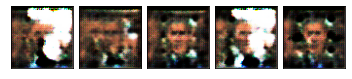

--- EPOCH 11/100 ---
100%|██████████| 67/67 [01:58<00:00,  1.76s/it]
Discriminator loss: 0.6758134038145862
Generator loss:     14.963003814220428
0.08033662036723269
Saved checkpoint.


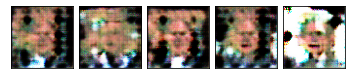

--- EPOCH 12/100 ---
100%|██████████| 67/67 [01:52<00:00,  1.68s/it]
Discriminator loss: 1.0372931957244873
Generator loss:     10.87005921308674
0.07886444760842633
Saved checkpoint.


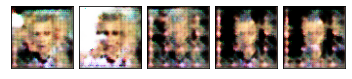

--- EPOCH 13/100 ---
100%|██████████| 67/67 [01:49<00:00,  1.63s/it]
Discriminator loss: 0.6489387278014155
Generator loss:     16.86610627396783
0.07436740731428233
Saved checkpoint.


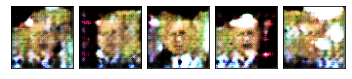

--- EPOCH 14/100 ---
100%|██████████| 67/67 [01:58<00:00,  1.77s/it]
Discriminator loss: 1.0530826841939742
Generator loss:     13.478464924577457
0.07378057467165335
Saved checkpoint.


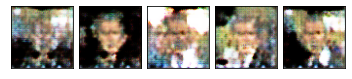

--- EPOCH 15/100 ---
100%|██████████| 67/67 [01:56<00:00,  1.74s/it]
Discriminator loss: 0.9173993572815141
Generator loss:     13.309912129124598
0.0696446256324038
Saved checkpoint.


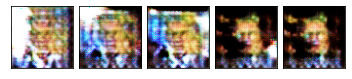

--- EPOCH 16/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.63s/it]
Discriminator loss: 0.9143704400022528
Generator loss:     13.30946356236045
0.06589732112014314
Saved checkpoint.


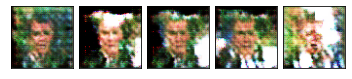

--- EPOCH 17/100 ---
100%|██████████| 67/67 [01:51<00:00,  1.66s/it]
Discriminator loss: 0.8262942736940597
Generator loss:     14.597095027788361
0.06202389793069578
Saved checkpoint.


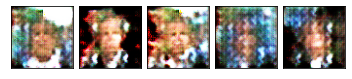

--- EPOCH 18/100 ---
100%|██████████| 67/67 [18:29:22<00:00, 993.47s/it]      
Discriminator loss: 0.8042860043360226
Generator loss:     13.767622583504043
0.058590261828733406
Saved checkpoint.


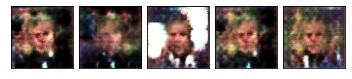

--- EPOCH 19/100 ---
100%|██████████| 67/67 [03:37<00:00,  3.25s/it]
Discriminator loss: 1.0050357148718478
Generator loss:     14.154110275542559
0.05723874193554504
Saved checkpoint.


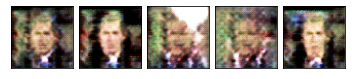

--- EPOCH 20/100 ---
100%|██████████| 67/67 [04:10<00:00,  3.74s/it]
Discriminator loss: 0.961027238573601
Generator loss:     12.657685183099847
0.05521158123507878
Saved checkpoint.


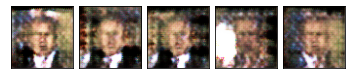

--- EPOCH 21/100 ---
100%|██████████| 67/67 [03:54<00:00,  3.50s/it]
Discriminator loss: 0.7252872374965184
Generator loss:     15.380524490751437
0.05312922273551833
Saved checkpoint.


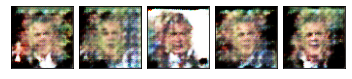

--- EPOCH 22/100 ---
100%|██████████| 67/67 [03:31<00:00,  3.15s/it]
Discriminator loss: 0.5071963066818999
Generator loss:     16.62931733344918
0.05523148480690742
Saved checkpoint.


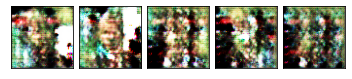

--- EPOCH 23/100 ---
100%|██████████| 67/67 [03:37<00:00,  3.25s/it]
Discriminator loss: -0.07057985908059931
Generator loss:     30.943115817966746
0.08545969155935372
Saved checkpoint.


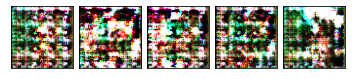

--- EPOCH 24/100 ---
100%|██████████| 67/67 [02:46<00:00,  2.48s/it]
Discriminator loss: 0.196592767736805
Generator loss:     30.59399654616171
0.095335588975966
Saved checkpoint.


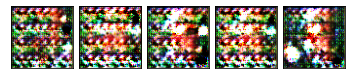

--- EPOCH 25/100 ---
100%|██████████| 67/67 [03:09<00:00,  2.83s/it]
Discriminator loss: 0.07071568227525968
Generator loss:     31.621585838830292
0.10937218104805849
Saved checkpoint.


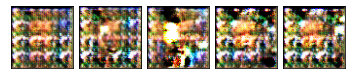

--- EPOCH 26/100 ---
100%|██████████| 67/67 [02:51<00:00,  2.55s/it]
Discriminator loss: 0.2743355042454022
Generator loss:     29.834007812302502
0.11268455604083386
Saved checkpoint.


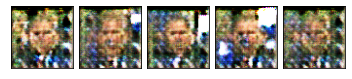

--- EPOCH 27/100 ---
100%|██████████| 67/67 [03:00<00:00,  2.70s/it]
Discriminator loss: 0.8571352037920881
Generator loss:     35.91616021341353
0.10930540071405297
Saved checkpoint.


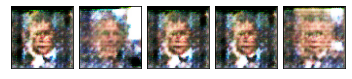

--- EPOCH 28/100 ---
100%|██████████| 67/67 [02:40<00:00,  2.40s/it]
Discriminator loss: 1.1531579407738215
Generator loss:     17.02699450903864
0.11206093365993322
Saved checkpoint.


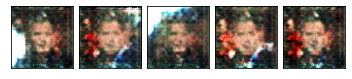

--- EPOCH 29/100 ---
100%|██████████| 67/67 [03:20<00:00,  3.00s/it]
Discriminator loss: 1.0084552197202818
Generator loss:     24.04553706254532
0.11079445289347235
Saved checkpoint.


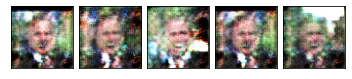

--- EPOCH 30/100 ---
100%|██████████| 67/67 [03:01<00:00,  2.71s/it]
Discriminator loss: 0.8938396430727261
Generator loss:     21.20673468886916
0.10787623522168815
Saved checkpoint.


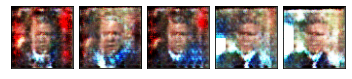

--- EPOCH 31/100 ---
100%|██████████| 67/67 [02:36<00:00,  2.33s/it]
Discriminator loss: 0.8517191460661924
Generator loss:     19.51732560747595
0.10475905901889422
Saved checkpoint.


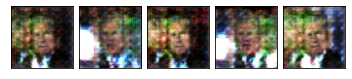

--- EPOCH 32/100 ---
100%|██████████| 67/67 [02:50<00:00,  2.55s/it]
Discriminator loss: 0.9114542774744888
Generator loss:     17.471921750413838
0.10230004454425516
Saved checkpoint.


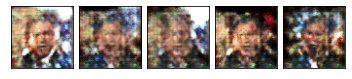

--- EPOCH 33/100 ---
100%|██████████| 67/67 [03:00<00:00,  2.70s/it]
Discriminator loss: 0.7143211149012865
Generator loss:     19.193324411760514
0.09924294987735553
Saved checkpoint.


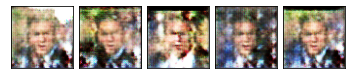

--- EPOCH 34/100 ---
100%|██████████| 67/67 [02:43<00:00,  2.44s/it]
Discriminator loss: 0.8394698113647859
Generator loss:     17.64399547185471
0.0965455803489863
Saved checkpoint.


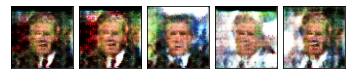

--- EPOCH 35/100 ---
100%|██████████| 67/67 [02:36<00:00,  2.34s/it]
Discriminator loss: 0.6611303943695862
Generator loss:     22.376074031662586
0.09402634285212791
Saved checkpoint.


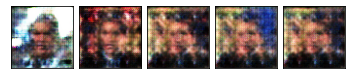

--- EPOCH 36/100 ---
100%|██████████| 67/67 [02:34<00:00,  2.30s/it]
Discriminator loss: 0.6288705984714316
Generator loss:     19.08301461009837
0.09181938615620172
Saved checkpoint.


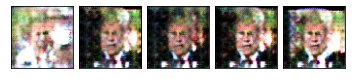

--- EPOCH 37/100 ---
100%|██████████| 67/67 [03:07<00:00,  2.79s/it]
Discriminator loss: 0.5930249872269915
Generator loss:     22.53942324843869
0.08996864090100902
Saved checkpoint.


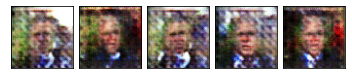

--- EPOCH 38/100 ---
100%|██████████| 67/67 [02:35<00:00,  2.33s/it]
Discriminator loss: 0.6625234618115781
Generator loss:     21.2125124664449
0.08777000329803858
Saved checkpoint.


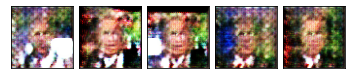

--- EPOCH 39/100 ---
100%|██████████| 67/67 [02:31<00:00,  2.26s/it]
Discriminator loss: 0.7133977820735369
Generator loss:     20.368113281566707
0.08553934679065704
Saved checkpoint.


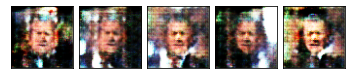

--- EPOCH 40/100 ---
100%|██████████| 67/67 [02:35<00:00,  2.33s/it]
Discriminator loss: 0.5659820350137219
Generator loss:     24.22825628963869
0.08414636412596907
Saved checkpoint.


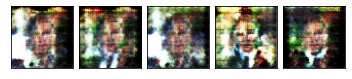

--- EPOCH 41/100 ---
100%|██████████| 67/67 [02:31<00:00,  2.26s/it]
Discriminator loss: 0.6583920184995479
Generator loss:     21.943095947379497
0.08223916583957033
Saved checkpoint.


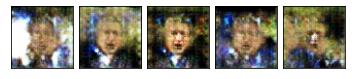

--- EPOCH 42/100 ---
100%|██████████| 67/67 [02:33<00:00,  2.29s/it]
Discriminator loss: 0.8654971243952637
Generator loss:     19.049466502199422
0.0806793938694524
Saved checkpoint.


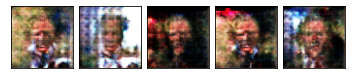

--- EPOCH 43/100 ---
100%|██████████| 67/67 [02:30<00:00,  2.25s/it]
Discriminator loss: 0.603602529128096
Generator loss:     20.062656968387206
0.07921163237127872
Saved checkpoint.


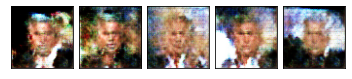

--- EPOCH 44/100 ---
100%|██████████| 67/67 [03:08<00:00,  2.81s/it]
Discriminator loss: 0.6601515380081846
Generator loss:     17.750201032677694
0.07753443239602618
Saved checkpoint.


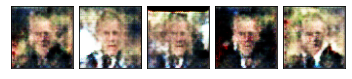

--- EPOCH 45/100 ---
100%|██████████| 67/67 [02:51<00:00,  2.56s/it]
Discriminator loss: 0.7106798173887516
Generator loss:     16.050087699916826
0.07582216933109114
Saved checkpoint.


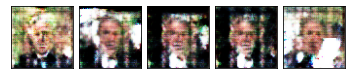

--- EPOCH 46/100 ---
100%|██████████| 67/67 [02:31<00:00,  2.26s/it]
Discriminator loss: 0.5386800737634524
Generator loss:     22.830123887133244
0.07497195917924929
Saved checkpoint.


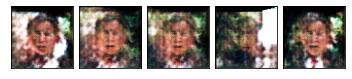

--- EPOCH 47/100 ---
100%|██████████| 67/67 [02:35<00:00,  2.32s/it]
Discriminator loss: 0.40961304373705565
Generator loss:     26.366742086499485
0.07549026927499083
Saved checkpoint.


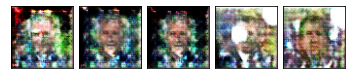

--- EPOCH 48/100 ---
100%|██████████| 67/67 [02:49<00:00,  2.53s/it]
Discriminator loss: 0.4847232281272091
Generator loss:     22.829763764765726
0.07506036408425766
Saved checkpoint.


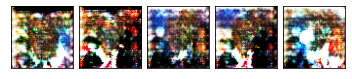

--- EPOCH 49/100 ---
100%|██████████| 67/67 [02:44<00:00,  2.46s/it]
Discriminator loss: 0.026904136331668542
Generator loss:     30.327585184752053
0.08303490456605635
Saved checkpoint.


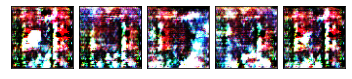

--- EPOCH 50/100 ---
100%|██████████| 67/67 [02:40<00:00,  2.40s/it]
Discriminator loss: 0.09293207481725892
Generator loss:     36.70860277716793
0.08865485774511563
Saved checkpoint.


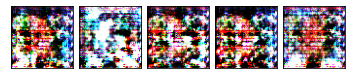

--- EPOCH 51/100 ---
100%|██████████| 67/67 [02:54<00:00,  2.60s/it]
Discriminator loss: 0.5184994986586606
Generator loss:     39.84486459529222
0.08748337949831377
Saved checkpoint.


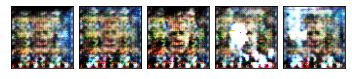

--- EPOCH 52/100 ---
100%|██████████| 67/67 [02:42<00:00,  2.43s/it]
Discriminator loss: 0.28073977859718585
Generator loss:     32.414334724198525
0.08891169103353157
Saved checkpoint.


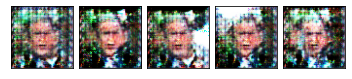

--- EPOCH 53/100 ---
100%|██████████| 67/67 [02:38<00:00,  2.36s/it]
Discriminator loss: 0.22130603109722707
Generator loss:     37.85104429666231
0.09111277673897722
Saved checkpoint.


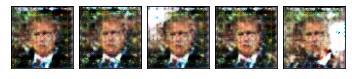

--- EPOCH 54/100 ---
100%|██████████| 67/67 [02:35<00:00,  2.31s/it]
Discriminator loss: 0.6798413941886887
Generator loss:     29.604726995327578
0.08942712128867442
Saved checkpoint.


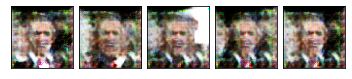

--- EPOCH 55/100 ---
100%|██████████| 67/67 [02:34<00:00,  2.30s/it]
Discriminator loss: 0.24285890795846485
Generator loss:     37.09519899425222
0.09106698218604799
Saved checkpoint.


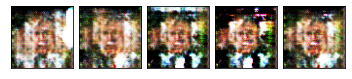

--- EPOCH 56/100 ---
100%|██████████| 67/67 [02:28<00:00,  2.22s/it]
Discriminator loss: 0.179099396844186
Generator loss:     30.40101458132267
0.09354421211049342
Saved checkpoint.


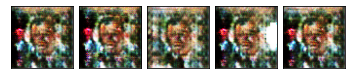

--- EPOCH 57/100 ---
100%|██████████| 67/67 [02:32<00:00,  2.28s/it]
Discriminator loss: -0.00319118681016253
Generator loss:     37.94563738623662
0.09935111462184662
Saved checkpoint.


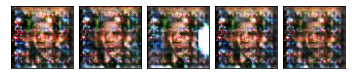

--- EPOCH 58/100 ---
100%|██████████| 67/67 [02:30<00:00,  2.24s/it]
Discriminator loss: 0.22759555202366702
Generator loss:     40.30087959232615
0.10055689922958527
Saved checkpoint.


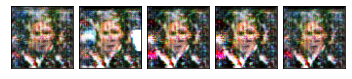

--- EPOCH 59/100 ---
100%|██████████| 67/67 [02:36<00:00,  2.33s/it]
Discriminator loss: 0.031323417687594
Generator loss:     37.87812460625349
0.10493417168876255
Saved checkpoint.


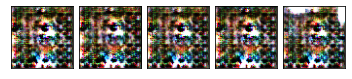

--- EPOCH 60/100 ---
100%|██████████| 67/67 [03:01<00:00,  2.70s/it]
Discriminator loss: 0.16421841296242246
Generator loss:     33.50721665015861
0.10666854552640632
Saved checkpoint.


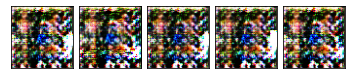

--- EPOCH 61/100 ---
100%|██████████| 67/67 [02:36<00:00,  2.34s/it]
Discriminator loss: 0.19634603914707455
Generator loss:     34.697789984185306
0.10778066512336913
Saved checkpoint.


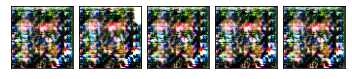

--- EPOCH 62/100 ---
100%|██████████| 67/67 [02:35<00:00,  2.33s/it]
Discriminator loss: -0.019467894210299447
Generator loss:     43.59620713920736
0.11234296860817099
Saved checkpoint.


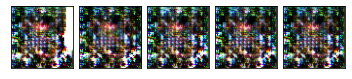

--- EPOCH 63/100 ---
100%|██████████| 67/67 [02:40<00:00,  2.39s/it]
Discriminator loss: -0.10706858325805237
Generator loss:     51.85864995130852
0.11838017335433947
Saved checkpoint.


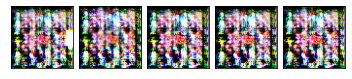

--- EPOCH 64/100 ---
100%|██████████| 67/67 [02:39<00:00,  2.38s/it]
Discriminator loss: 0.028295343713973884
Generator loss:     49.57315470033617
0.12137046525631828
Saved checkpoint.


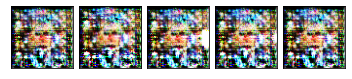

--- EPOCH 65/100 ---
100%|██████████| 67/67 [02:31<00:00,  2.27s/it]
Discriminator loss: 0.4044520780444145
Generator loss:     36.46667105315336
0.11997265148604626
Saved checkpoint.


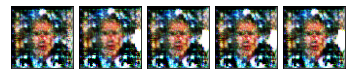

--- EPOCH 66/100 ---
100%|██████████| 67/67 [02:09<00:00,  1.93s/it]
Discriminator loss: 0.11003812291284105
Generator loss:     47.6686854825091
0.1214195675634852
Saved checkpoint.


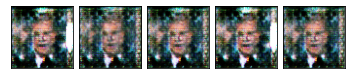

--- EPOCH 67/100 ---
100%|██████████| 67/67 [01:50<00:00,  1.65s/it]
Discriminator loss: 0.5407400115657208
Generator loss:     42.41447473395227
0.11962052756521076
Saved checkpoint.


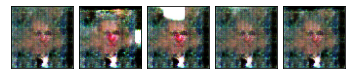

--- EPOCH 68/100 ---
100%|██████████| 67/67 [01:51<00:00,  1.67s/it]
Discriminator loss: 0.8573828121063425
Generator loss:     30.290189727918424
0.1190560227933
Saved checkpoint.


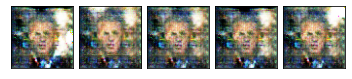

--- EPOCH 69/100 ---
100%|██████████| 67/67 [01:50<00:00,  1.65s/it]
Discriminator loss: 0.47754759330358076
Generator loss:     33.21075927499515
0.11746474470365986
Saved checkpoint.


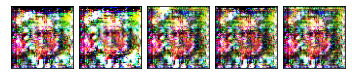

--- EPOCH 70/100 ---
100%|██████████| 67/67 [02:13<00:00,  1.99s/it]
Discriminator loss: 0.13622891177325996
Generator loss:     43.16532749397708
0.11847382096189096
Saved checkpoint.


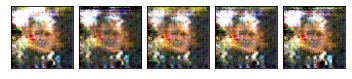

--- EPOCH 71/100 ---
100%|██████████| 67/67 [01:51<00:00,  1.66s/it]
Discriminator loss: 0.9273038743925628
Generator loss:     34.524945485141515
0.11860961011236414
Saved checkpoint.


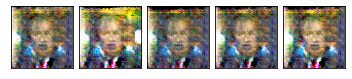

--- EPOCH 72/100 ---
100%|██████████| 67/67 [01:49<00:00,  1.64s/it]
Discriminator loss: 0.2517147904345349
Generator loss:     38.0915954789119
0.11836636594503802
Saved checkpoint.


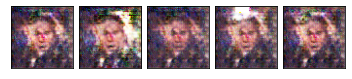

--- EPOCH 73/100 ---
100%|██████████| 67/67 [01:51<00:00,  1.67s/it]
Discriminator loss: 0.36744244919339225
Generator loss:     41.03504411531473
0.11728541614603606
Saved checkpoint.


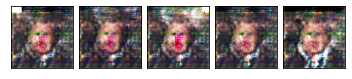

--- EPOCH 74/100 ---
100%|██████████| 67/67 [01:50<00:00,  1.64s/it]
Discriminator loss: 0.42252432643922405
Generator loss:     31.558983902433024
0.11597000531211822
Saved checkpoint.


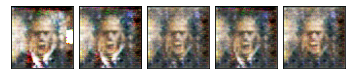

--- EPOCH 75/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.62s/it]
Discriminator loss: 0.32763135633361873
Generator loss:     37.55521084746318
0.1151512580464837
Saved checkpoint.


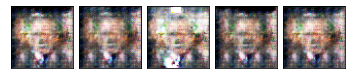

--- EPOCH 76/100 ---
100%|██████████| 67/67 [01:49<00:00,  1.63s/it]
Discriminator loss: 0.20599770156750039
Generator loss:     37.324242408595865
0.11526018875196993
Saved checkpoint.


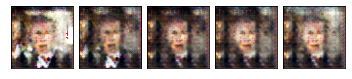

--- EPOCH 77/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.61s/it]
Discriminator loss: 0.23903652792101476
Generator loss:     36.68460912824567
0.11504303488151196
Saved checkpoint.


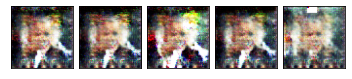

--- EPOCH 78/100 ---
100%|██████████| 67/67 [01:47<00:00,  1.61s/it]
Discriminator loss: 0.4663368839381346
Generator loss:     41.92079381800409
0.11365862997199451
Saved checkpoint.


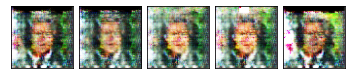

--- EPOCH 79/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.62s/it]
Discriminator loss: 0.8115869305138268
Generator loss:     35.25106833941901
0.11307631895735677
Saved checkpoint.


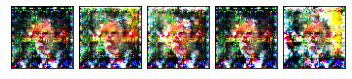

--- EPOCH 80/100 ---
100%|██████████| 67/67 [01:50<00:00,  1.65s/it]
Discriminator loss: 0.24645625335623078
Generator loss:     34.382487597305385
0.11282378453052253
Saved checkpoint.


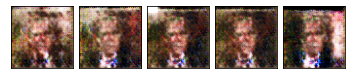

--- EPOCH 81/100 ---
100%|██████████| 67/67 [01:49<00:00,  1.63s/it]
Discriminator loss: 0.491815193014136
Generator loss:     35.78700802475214
0.11147118706651621
Saved checkpoint.


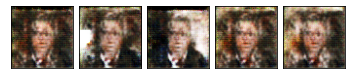

--- EPOCH 82/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.62s/it]
Discriminator loss: 0.4894300531317939
Generator loss:     37.34259036594807
0.11015394005295895
Saved checkpoint.


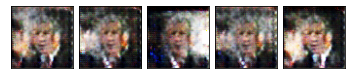

--- EPOCH 83/100 ---
100%|██████████| 67/67 [01:49<00:00,  1.64s/it]
Discriminator loss: 0.7694928291351048
Generator loss:     31.619112644177765
0.10941144208857488
Saved checkpoint.


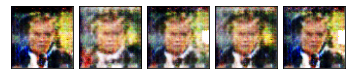

--- EPOCH 84/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.63s/it]
Discriminator loss: 0.7206524141244034
Generator loss:     27.350929475097512
0.10844934118747315
Saved checkpoint.


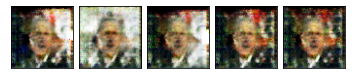

--- EPOCH 85/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.62s/it]
Discriminator loss: 0.6749271920590258
Generator loss:     23.91934504304359
0.10734755130981302
Saved checkpoint.


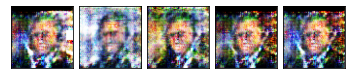

--- EPOCH 86/100 ---
100%|██████████| 67/67 [01:50<00:00,  1.65s/it]
Discriminator loss: 0.696117791444508
Generator loss:     28.450141351169616
0.10633144373662197
Saved checkpoint.


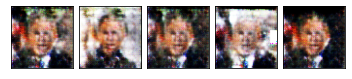

--- EPOCH 87/100 ---
100%|██████████| 67/67 [01:47<00:00,  1.60s/it]
Discriminator loss: 0.3920713639192617
Generator loss:     26.698073291066866
0.10541328440302114
Saved checkpoint.


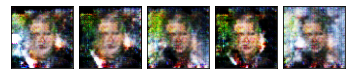

--- EPOCH 88/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.62s/it]
Discriminator loss: 0.24079954560234476
Generator loss:     29.991643137006616
0.1053158552649994
Saved checkpoint.


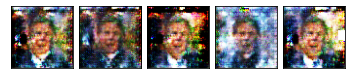

--- EPOCH 89/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.62s/it]
Discriminator loss: 0.41548446082134743
Generator loss:     33.56120160444459
0.10433420356214508
Saved checkpoint.


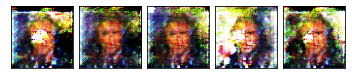

--- EPOCH 90/100 ---
100%|██████████| 67/67 [01:51<00:00,  1.66s/it]
Discriminator loss: 0.3330732483917208
Generator loss:     29.976902723312378
0.10368581873006993
Saved checkpoint.


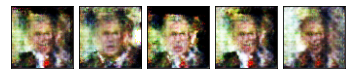

--- EPOCH 91/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.62s/it]
Discriminator loss: 0.909860144855816
Generator loss:     36.64927755629839
0.10398287978262946
Saved checkpoint.


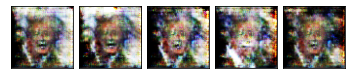

--- EPOCH 92/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.61s/it]
Discriminator loss: 0.38586093390833087
Generator loss:     31.249415939423574
0.10314335945825795
Saved checkpoint.


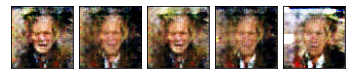

--- EPOCH 93/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.61s/it]
Discriminator loss: 0.5013482203123285
Generator loss:     26.375161118249395
0.10205795521987335
Saved checkpoint.


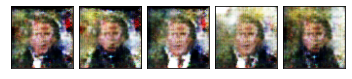

--- EPOCH 94/100 ---
100%|██████████| 67/67 [01:47<00:00,  1.60s/it]
Discriminator loss: 0.5177386697770944
Generator loss:     29.803255528656404
0.1009818755201405
Saved checkpoint.


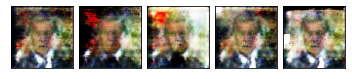

--- EPOCH 95/100 ---
100%|██████████| 67/67 [01:48<00:00,  1.61s/it]
Discriminator loss: 0.7382767291656182
Generator loss:     31.343544501422056
0.10029725157074368
Saved checkpoint.


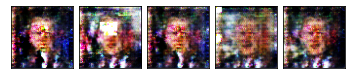

--- EPOCH 96/100 ---
100%|██████████| 67/67 [01:47<00:00,  1.60s/it]
Discriminator loss: 0.4269962638838967
Generator loss:     28.183637400394055
0.09940766969881211
Saved checkpoint.


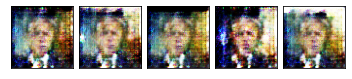

--- EPOCH 97/100 ---
100%|██████████| 67/67 [01:49<00:00,  1.64s/it]
Discriminator loss: 0.4442341191999948
Generator loss:     25.433466869948514
0.09849358556630124
Saved checkpoint.


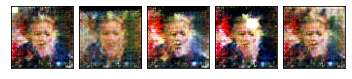

--- EPOCH 98/100 ---
100%|██████████| 67/67 [01:47<00:00,  1.60s/it]
Discriminator loss: 0.2513325772067504
Generator loss:     35.09464190967047
0.0983735098332518
Saved checkpoint.


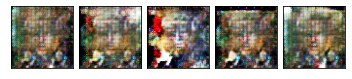

--- EPOCH 99/100 ---
100%|██████████| 67/67 [01:47<00:00,  1.61s/it]
Discriminator loss: 0.383931086023352
Generator loss:     33.60151081743525
0.09763705546960558
Saved checkpoint.


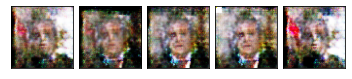

--- EPOCH 100/100 ---
100%|██████████| 67/67 [01:47<00:00,  1.61s/it]
Discriminator loss: 0.2989516895987205
Generator loss:     39.94391040303814
0.09724887206302774
Saved checkpoint.


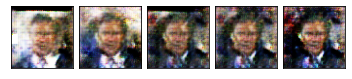

In [135]:
import IPython.display
import tqdm
from hw4.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device,)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

In [ ]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw4/answers.py`.

In [136]:
from cs236781.answers import display_answer
import hw4.answers as answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [137]:
display_answer(answers.part3_q1)


**Your answer:**
When training the discriminator, we use the generator as a "black box" to generate some samples as adversarial inputs.
We optimize $\delta$ for the discriminator and $\gamma$ for the generator which are different parameters.
The optimization of the discriminator ($\delta$) should not be based on the gradients of the generator ($\gamma$) as the loss function we minimize
is derived for the discriminator, and therefore we discard gradients calculated in the generator.

However when training the Generator, we would optimize the loss function of the generator (Optimize $\gamma$) and therefore
we will maintain the gradients.


### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [138]:
display_answer(answers.part3_q2)


1. 
We should not base our stop-point for training solely based on the gen-loss as the total loss of the training is based
also on the discriminator loss, and there may be situations where the gen-loss does not satisfy a certain threshold, however
with that specific generator the discriminator achieves better results, and the total loss improves.

In addition, when training the generator we cannot use the discriminator as "black box" in same manner we treated the generator
when training the discriminator, and that is mainly because the loss of the generator depends on output (and gradients) that
are passed though the discriminator, and that is the only way the generator receives any information from the input data.
 (With the discriminator we would stop at the discriminator block and not look at the 
generator gradients).

2.
Given that the generator loss is decreasing, which is the term:
$gen\ loss=-\mathbb{E}_{z\sim p(Z)}\log(\Delta_{\delta}(\Psi_{\gamma}(z)))$
We can infer that the term in the discriminator loss $-\mathbb{E}_{z\sim p(Z)}\log(1-\Delta_{\delta}(\Psi_{\gamma}(z)))$ is increasing.
However since the discriminator loss remains constant, the term $-\mathbb{E}_{x\sim p(X)}\log\Delta_{\delta}(x)$ in the discriminator
should decrease to keep the value constant.
The term represent how well we identify real data, and therefore this scenario implies that the training processes is working properly,
and that the model identifies better real data, however since $\mathbb{E}_{z\sim p(Z)}\log(1-\Delta_{\delta}(\Psi_{\gamma}(z))$
increased, we can assume identifying generated data gets worse.


### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [139]:
display_answer(answers.part3_q3)


The main differences between the generated images of the two models are:

- VAE generated images seem to be much more blurry than the GAN generated images that are much sharper.
- GAN generated images seem to be less similar to "Bush" real appearance, and seem to generate a sharper looking images of
a "fake bush".

We can explain these differences as the result of the following:

- GAN models are notoriously hard to train as mentioned in tutorials and lectures, and as we experienced with different hyper-params
and discriminator/generator architectures. 
This might cause the GAN model to produce clear images, however at the price of producing ingenuous images.

- VAE model minimizes loss between latent space distribution to a normal distribution, therefore when sampling from a normal
distribution to reconstruct the images we actually sample closer to the actual latent space, and combined with the data-loss
we produce images that represent more the input images (in out case "Bush" images) 
